In [1]:
import matplotlib.pylab as pl
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import minpy
import minpy.nn.model_builder as builder
import minpy.numpy as np
import numpy as np0
from facility import to_np
from solver_primitives import *

In [2]:
minpy.set_global_policy(minpy.policy.OnlyNumPyPolicy())

In [10]:
def to_approximate(X, Y):
#     return np0.sin(np0.cos(X)) + np0.cos(np0.sin(Y))
    return np0.sin(1 / X) + np0.sin(1 / Y)

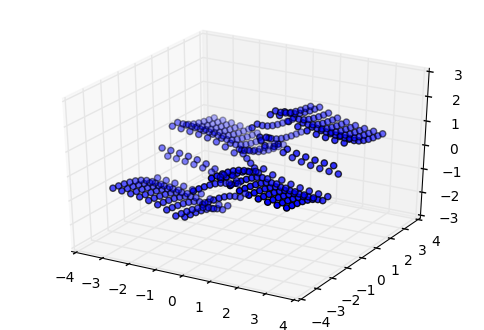

In [11]:
N_X, N_Y = 20, 20
X = np0.linspace(-np0.pi, np0.pi, N_X)
Y = np0.linspace(-np0.pi, np0.pi, N_Y)
EXTENDED_X, EXTENDED_Y = np0.meshgrid(X, Y)
XARRAY = np0.vstack((EXTENDED_X.flatten(), EXTENDED_Y.flatten())).T
Z = to_approximate(EXTENDED_X, EXTENDED_Y)
ZARRAY = np0.vstack(Z.flatten())
figure = pl.figure()
axis = figure.gca(projection='3d')
axis.scatter(EXTENDED_X.flatten(), EXTENDED_Y.flatten(), Z.flatten())

In [5]:
def MSE(predictions, Y):
    return np.sum((predictions - Y) ** 2) / Y.shape[0]
ITERATIONS = 100
LOGGING_INTERVAL = ITERATIONS + 1

In [6]:
conventional_network = builder.Sequential(
    builder.Affine(256),
    builder.ReLU(),
    builder.Affine(256),
    builder.ReLU(),
    builder.Affine(256),
    builder.ReLU(),
    builder.Affine(1),
)
conventional_model = builder.Model(conventional_network, MSE, (2,))
initialize(conventional_model)
updater = Updater(conventional_model, 'sgd', {'learning_rate' : 0.001})
conventional_network_loss_history = []
for iteration in range(ITERATIONS):
    gradients, loss = gradient_loss(conventional_model, XARRAY, ZARRAY)
    updater.update(gradients)
    conventional_network_loss_history.append(loss)
    if (iteration + 1) % LOGGING_INTERVAL == 0:
        print 'iteration %d loss %f' % (iteration + 1, to_np(loss))

In [7]:
decoupled_network = builder.Sequential(
    builder.Add(
        builder.Affine(1),
        builder.Sequential(
            builder.Affine(16),
            builder.ReLU(),
            builder.Affine(1)
)))
decoupled_model = builder.Model(decoupled_network, MSE, (2,))
initialize(decoupled_model)
updater = Updater(decoupled_model, 'sgd', {'learning_rate' : 0.1})
decoupled_network_loss_history = []
for iteration in range(ITERATIONS):
    gradients, loss = gradient_loss(decoupled_model, XARRAY, ZARRAY)
    updater.update(gradients)
    decoupled_network_loss_history.append(loss)
    if (iteration + 1) % LOGGING_INTERVAL == 0:
        print 'iteration %d loss %f' % (iteration + 1, to_np(loss))

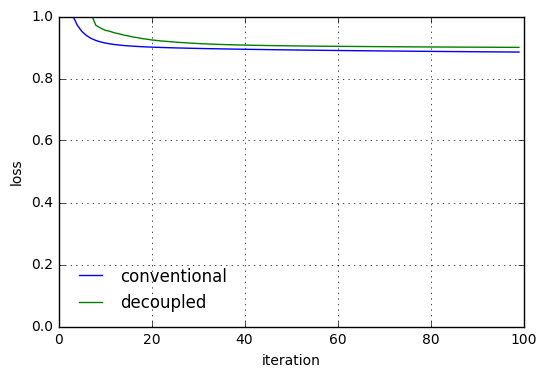

In [8]:
pl.plot(range(ITERATIONS), conventional_network_loss_history, label='conventional')
pl.plot(range(ITERATIONS), decoupled_network_loss_history, label='decoupled')
pl.ylim(0, 1)
pl.xlabel('iteration')
pl.ylabel('loss')
pl.grid()
pl.legend(framealpha=0, loc='best')

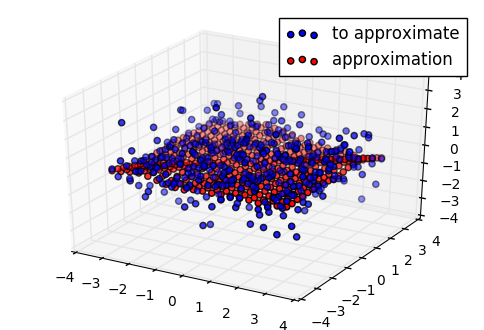

In [9]:
predictions = conventional_model.forward(XARRAY, 'test')
figure = pl.figure()
axis = figure.gca(projection='3d')
axis.scatter(EXTENDED_X.flatten(), EXTENDED_Y.flatten(), Z.flatten(), c='b', label='to approximate')
axis.scatter(EXTENDED_X.flatten(), EXTENDED_Y.flatten(), to_np(predictions).flatten(), c='r', label='approximation')
pl.legend()